## 第６章 RAG 構築実践

こちらの Notebook は、書籍第６章のサンプルコードの一部が入っています。

必要ライブラリのインストールを行います。

In [ ]:
!pip install -r requirements.txt

In [ ]:
import json
from pprint import pprint

import boto3
from mypy_boto3_bedrock_runtime.client import BedrockRuntimeClient
from mypy_boto3_bedrock_agent.client import AgentsforBedrockClient
from mypy_boto3_bedrock_agent_runtime.client import AgentsforBedrockRuntimeClient


# 作成したナレッジベースの情報。マネジメントコンソール上で確認できます。
knowledge_base_id = "XXXXXXX"
data_source_id = "XXXXXXXXX"

# 推論用テキストモデルの情報
model_id = "anthropic.claude-3-5-haiku-20241022-v1:0"
region = "us-west-2"

agents_client: "AgentsforBedrockClient" = boto3.client(
    "bedrock-agent", region_name=region)
agents_runtime_client: "AgentsforBedrockRuntimeClient" = boto3.client(
    "bedrock-agent-runtime", region_name=region)
bedrock_runtime_client: "BedrockRuntimeClient" = boto3.client(
    service_name="bedrock-runtime", region_name=region)

## 検索

`retrieve` のドキュメントはこちらです。  
https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve.html

In [ ]:
query = "東京都　人口"
response = agents_runtime_client.retrieve(
    knowledgeBaseId=knowledge_base_id,
    retrievalConfiguration={
        "vectorSearchConfiguration": {
            "overrideSearchType": "HYBRID", # "SEMANTIC" にするとベクター検索の結果だけ返ってきます
            "numberOfResults": 3
        }
    },
    retrievalQuery={
        "text": query
    }
)
# 結果をわかりやすく可視化するために pprint を使用
pprint(response)

## RAG のフローの作成
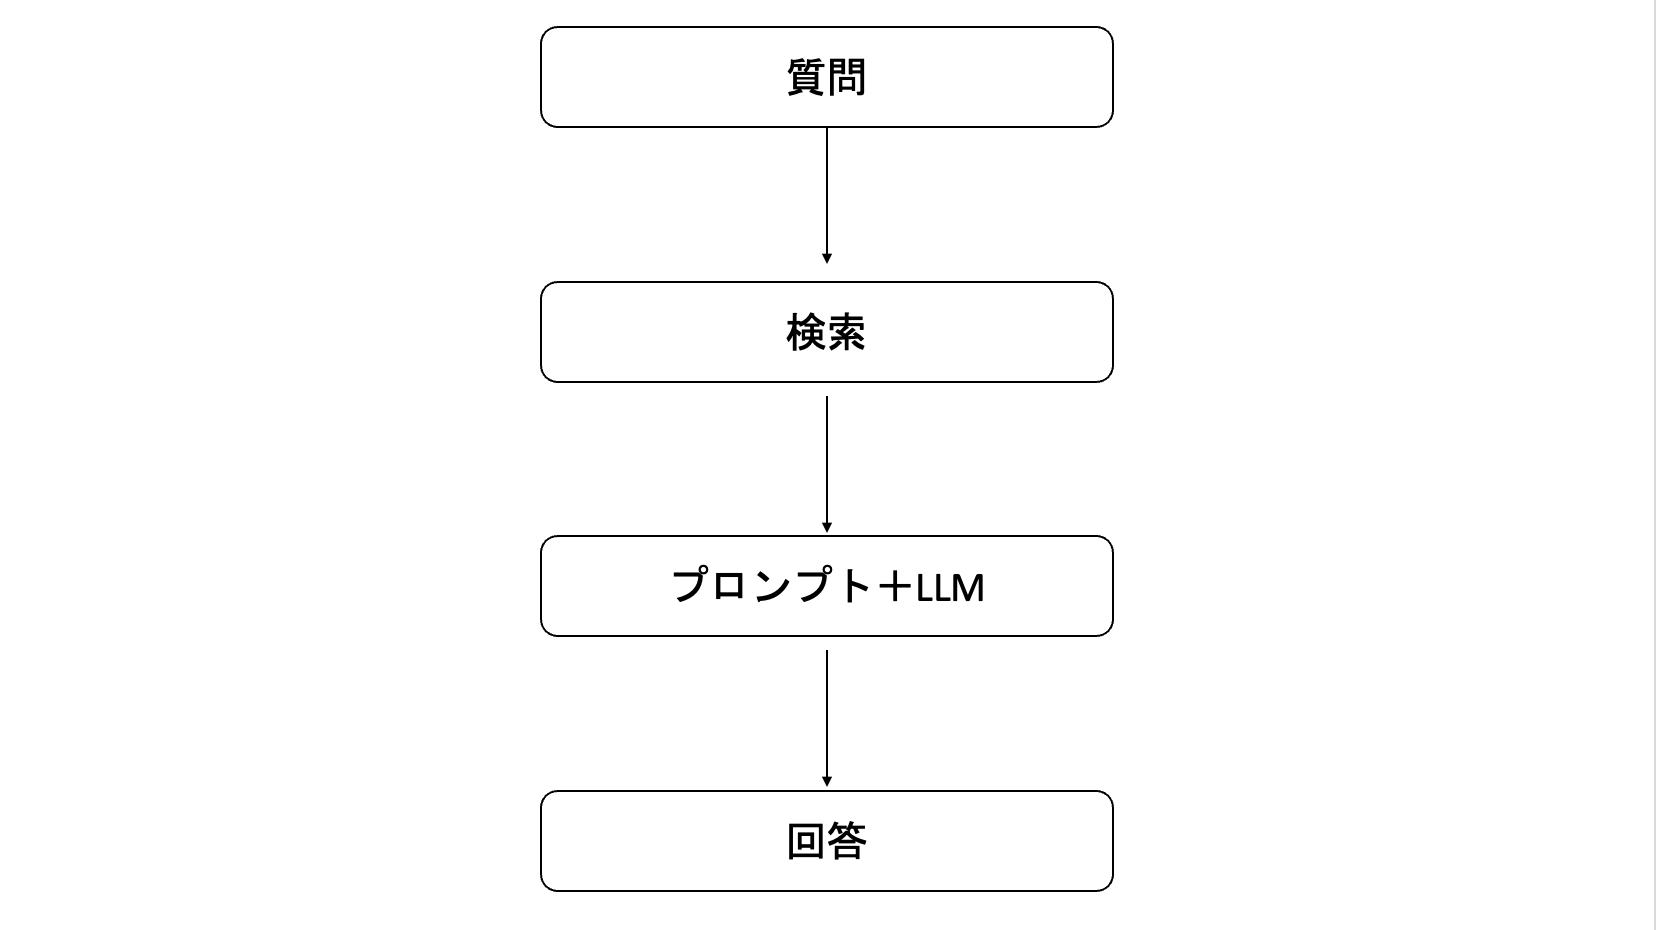


In [ ]:
prompt_template = \
"""下記<context></context>はユーザーから問い合わせられた質問に対して関係があると思われる検索結果の一覧です。
注意深く読んでください。
<context>
{context}
</context>
あなたは親切なAIボットです。ユーザからの質問に対して<context></context>で与えられている情報をもとに誠実に回答します。
ただし、質問に対する答えが<context></context>に書かれていない場合は、正直に「分かりません。」と回答してください。

下記<question></question>がユーザーからの質問です。
<question>
{question}
</question>
ユーザーからの質問に回答してください。

なお、ユーザーからの質問に回答する前に<thinking></thinking>タグで思考過程を記してから回答内容を<answer></answer>に加えてください。
"""

In [ ]:
def invoke_llm(prompt: str, model_id: str, bedrock_runtime_client) -> str:
    """Converse API を使って、 LLM を呼び出す
    """
    response = bedrock_runtime_client.converse(
        modelId=model_id,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "text": prompt
                    }
                ],
            }
        ],
        inferenceConfig={
            "temperature": 0.0
        }
    )
    result = response['output']['message']['content'][0]['text']
    return result

In [ ]:
def retrieve_context(
    query: str,
    knowledge_base_id: str,
    agents_runtime_client: "AgentsforBedrockRuntimeClient"
) -> list[dict]:
    """ナレッジベースに対して検索をかけて関連するドキュメントを取得する
    """
    response = agents_runtime_client.retrieve(
        knowledgeBaseId=knowledge_base_id,
        retrievalConfiguration={
            "vectorSearchConfiguration": {
                "overrideSearchType": "HYBRID", # 'SEMANTIC' にするとベクター検索の結果だけ返ってきます
                "numberOfResults": 3
            }
        },
        retrievalQuery={
            "text": query
        }
    )
    return response["retrievalResults"]

In [ ]:
def ask_question_naive_rag(
    question: str,
    knowledge_base_id: str,
    agents_runtime_client: "AgentsforBedrockRuntimeClient",
    bedrock_runtime_client: "BedrockRuntimeClient"
) -> str:
    """質問→検索→LLm→回答 という最もシンプルな流れを実現する
    """
    context = retrieve_context(question, knowledge_base_id, agents_runtime_client)
    prompt = prompt_template.format(
        context=json.dumps(context),
        question=question
    )
    llm_response = invoke_llm(prompt, model_id, bedrock_runtime_client)
    print("retrieved context")
    print("="*30)
    print("\n".join(_context["content"]["text"] for _context in context))
    print("="*30)
    return llm_response

In [ ]:
%%time
answer = ask_question_naive_rag(
    "東京都の地下鉄路線一覧を教えて。", knowledge_base_id,
    agents_runtime_client,
    bedrock_runtime_client
)
print(answer)

### Streamlit で RAG アプリをホストする

Knowledge Base の ID などを環境変数としてセットするために、.env ファイルに格納する。

In [ ]:
!echo "KNOWLEDGE_BASE_ID=$knowledge_base_id" > .env
!echo "DATA_SOURCE_ID=$data_source_id" >> .env
!cat .env

In [ ]:
!streamlit run app/app.py  --server.baseUrlPath="/proxy/absolute/8501"

## 評価を実施する

In [ ]:
import os
import json
import re
import time
from pprint import pprint
from typing import Callable, Tuple, Any, TYPE_CHECKING

import boto3
import pandas as pd
from dotenv import load_dotenv

if TYPE_CHECKING:
    from mypy_boto3_bedrock_agent_runtime.client import AgentsforBedrockRuntimeClient
    from mypy_boto3_bedrock_runtime.client import BedrockRuntimeClient

from app.logics.rag_logics import call_rag


# 環境変数の読み込み
load_dotenv(".env", verbose=True)

KNOWLEDGE_BASE_ID = os.environ.get("KNOWLEDGE_BASE_ID")
# MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"
# MODEL_ID = "anthropic.claude-3-5-haiku-20241022-v1:0"
EMBEDDING_MODEL_ID = "amazon.titan-embed-text-v2:0"  # 評価時に使用する埋め込みモデル
REGION = "us-west-2"

agents_for_bedrock_runtime: "AgentsforBedrockRuntimeClient" = boto3.client(
    "bedrock-agent-runtime", region_name=REGION)
bedrock_runtime_client: "BedrockRuntimeClient" = boto3.client(
    service_name="bedrock-runtime",
    region_name=REGION
)

CallRAGType = Callable[
    [str, str, 'AgentsforBedrockRuntimeClient', 'BedrockRuntimeClient', str],
    Tuple[str, list[dict[str, Any]]]
]

def make_call_rag_func(
    call_rag: CallRAGType,
    knowledge_base_id: str,
    agents_for_bedrock_runtime: "AgentsForBedrockRuntimeClient",
    bedrock_runtime_client: "BedrockRuntimeClient",
) -> Callable[[str], "pd.Series"]:
    """アプリの中で定義されている call_rag 関数を評価に使えるように中身を調整するための関数
    """
    def _call_rag(question: str) -> "pd.Series":
        start_time = time.time()
        response, context = call_rag(
            question,
            knowledge_base_id,
            agents_for_bedrock_runtime,
            bedrock_runtime_client
        )
        end_time = time.time()
        execution_seconds = end_time - start_time
        context_texts = [json.dumps(_context, ensure_ascii=False) for _context in context]
        answer_pattern = r"<answer>(.*?)</answer>"
        answer = "".join(re.findall(answer_pattern, response, re.DOTALL))
        return pd.Series(
            {
                "answer": answer,
                "retrieved_contexts": context_texts,
                "execution_seconds": execution_seconds
            })
    return _call_rag

In [ ]:
eval_data = pd.read_csv("./eval/eval_data.csv")
eval_data

In [ ]:
rag_func = make_call_rag_func(
    call_rag,
    KNOWLEDGE_BASE_ID,
    agents_for_bedrock_runtime, bedrock_runtime_client)

new_dataset = eval_data["question"].apply(
    lambda x: rag_func(x)
)
eval_data[["response", "retrieved_contexts", "execution_seconds"]] = new_dataset
eval_data

In [ ]:
eval_data.to_csv("./eval/full_eval_data.csv", index=None)

### ragas を使った評価の実施

In [ ]:
from datasets import load_dataset, Dataset

from langchain_aws import ChatBedrockConverse, BedrockEmbeddings
from ragas import evaluate 
from ragas.metrics import answer_relevancy, answer_similarity, context_recall, faithfulness

In [ ]:
MODEL_ID = "anthropic.claude-3-5-haiku-20241022-v1:0"

eval_dataset = Dataset.from_pandas(eval_data)

bedrock_model = ChatBedrockConverse(
    client=bedrock_runtime_client,
    model=MODEL_ID,
    temperature=0.0
)

bedrock_embedding_model = BedrockEmbeddings(
    client=bedrock_runtime_client,
    model_id=EMBEDDING_MODEL_ID
)
result = evaluate(
    eval_dataset,
    metrics=[answer_relevancy, answer_similarity, context_recall, faithfulness],
    llm=bedrock_model,
    embeddings=bedrock_embedding_model,
)
print(result)

In [ ]:
# 文字列を全て表示されるように設定
pd.options.display.max_colwidth = 1000

In [ ]:
result.to_pandas()[
    ["user_input", "response", "answer_relevancy", "semantic_similarity", "context_recall", "faithfulness"]
]

In [ ]:
!streamlit run app/app.py  --server.baseUrlPath="/proxy/absolute/8501"

### 評価パイプラインの構築

これから RAG アプリを改善していくにあたって改善した RAG システムの性能をトラッキングするためのパイプラインを整備しておきます。  
具体的には、改善した RAG アプリの返答生成関数を入れ替えるだけで手軽に評価指標の出力を結果の保存までを行うものを想定します。

In [ ]:
%pycat ./eval/eval_rag.py

In [ ]:
from eval.eval_rag import evaluate_rag
from app.logics.rag_logics_6_3_1 import call_rag as call_rag_6_3_1
from app.logics.rag_logics_6_3_3 import call_rag as call_rag_6_3_3

In [ ]:
rag_func = make_call_rag_func(
    call_rag_6_3_1,
    KNOWLEDGE_BASE_ID,
    agents_for_bedrock_runtime,
    bedrock_runtime_client
)
result_6_3_1 = evaluate_rag(rag_func, eval_name="6_3_1_prompt_improvement")

### データソースに、東京都の地下鉄の情報について追加

Wikipedia の東京の地下鉄ページの内容を html ファイルとして保存して、S3 バケットにアップロードします。  
https://ja.wikipedia.org/wiki/%E6%9D%B1%E4%BA%AC%E3%81%AE%E5%9C%B0%E4%B8%8B%E9%89%84


データソースのチャンキングをアップデートして検索結果を確認。

In [ ]:
query = "東京 地下鉄 路線"
response = agents_for_bedrock_runtime.retrieve(
    knowledgeBaseId=KNOWLEDGE_BASE_ID,
    retrievalConfiguration={
        'vectorSearchConfiguration': {
            'overrideSearchType': 'SEMANTIC', # 'HYBRID' にするとキーワード検索の結果と統合されます
            'numberOfResults': 5
        }
    },
    retrievalQuery={
        'text': query
    }
)
pprint(response)

In [ ]:
rag_func = make_call_rag_func(
    call_rag_6_3_3,
    KNOWLEDGE_BASE_ID,
    agents_for_bedrock_runtime,
    bedrock_runtime_client
)
result_6_3_3 = evaluate_rag(rag_func, eval_name="6_3_3_retrieve_improvement")